### Quora Question Pairs: identifying two questions of the same intent 

This notebook provides some insight into n-grams as a potential classifier for determining whether a pair of questions on Quora is asking the same question.

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from subprocess import check_output

In [5]:
print(check_output(["ls", "/Users/SojungKi/Desktop/dataset/quora"]).decode("utf8"))

quora_sample_submission.csv
quora_test.csv
quora_train.csv



In [3]:
train = pd.read_csv("../dataset/quora/quora_train.csv")

## EDA

In [7]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


***How many pairs are duplicates of each other?***

In [9]:
dupes = train["is_duplicate"].value_counts()

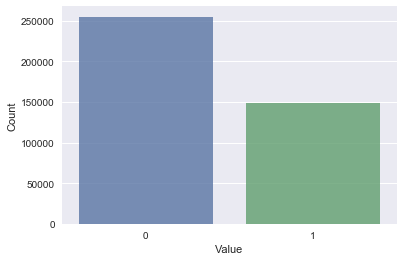

In [10]:
sns.barplot(dupes.index, dupes.values, alpha=0.8)
plt.ylabel("Count")
plt.xlabel("Value")

In [11]:
round(train["is_duplicate"].mean()*100,2)

36.92

So we have about 36% of dupes.

***Create a Word Cloud : What are the most common words?***

In [12]:
#create a vector of questions
questions = pd.Series(train['question1'].tolist() + 
                     train['question2'].tolist()).astype(str)

In [13]:
#create wordcloud of the question vector
#from os import path
from wordcloud import WordCloud, STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

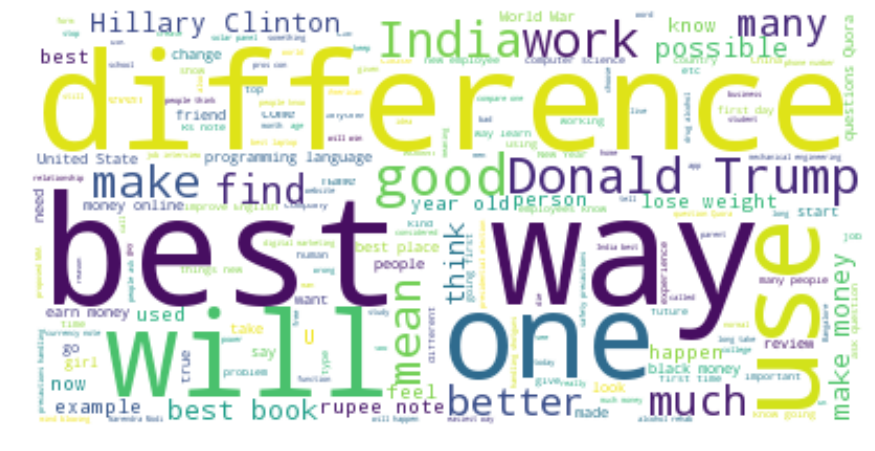

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(wordMap,interpolation="bilinear")
plt.axis("off")

In [14]:
all_words = " ".join(questions.astype(str))
stopwords=set(STOPWORDS)
wc = WordCloud(background_color="white", stopwords=stopwords) #remove english stopwords
wordMap = wc.generate(text =all_words)

We want to assign less significance to common words when determining duplicates.

***Trend in word length and character length***

In [4]:
#a new traing set to work with
ntrain = train

In [4]:
#pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
#character length variable 
ntrain['q1_char_len'] = ntrain['question1'].str.len()
ntrain['q2_char_len'] = ntrain['question2'].str.len()

#word length variable
ntrain['q1_word_len'] = ntrain['question1'].apply(lambda n: len(str(n).split(" ")))
ntrain['q2_word_len'] = ntrain['question2'].apply(lambda n: len(str(n).split(" ")))

/Users/SojungKi/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


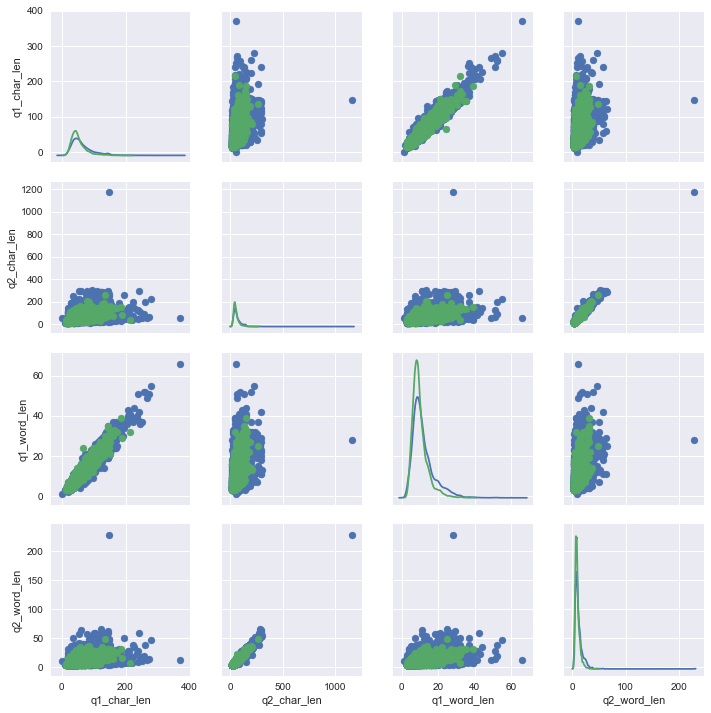

In [9]:
#graph the new dataframe
g = sns.PairGrid(ntrain[0:10000], vars = ['q1_char_len','q2_char_len','q1_word_len','q2_word_len'],
                 hue = 'is_duplicate')
g.map_offdiag(plt.scatter)
g.map_diag(sns.kdeplot)

3 obervations from this figure:
1. The slope of the linear relationship is less steep for non-duplicates. 
    - The slope is near 0.25 for the first segment (0~200 'char_diff'). 
    - The slope decreases to 0.20 for the last segment (400~1000 'char_diff'). This segment contains only non-duplicates; therefore, we can assume that questions with unusually long/complicated words are less likely to have duplicates. (ie. long words can serve as key words with high significance)
2. Duplicates are usually 'short' questions within word length of 50 or character length of 200 (about 1~5 sentences). This indicates that duplicates tend to be concise/simple sentences with not much detailed explanation. 
3. Non-duplicate observations have overall larger variance. But this is not that useful.

***n-grams (n consecutive words)***

1) 1-grams: number of words shared by two questions
- We will only consider keywords excluding punctuations and stopwords

In [224]:
#spacy is faster than nltk
from spacy.en import English

In [17]:
nlp = English()

In [123]:
#tokenize text
def tokenize(line):   
    parsed_data = [t for t in nlp(line.lower())]
    return(parsed_data)

#create token variable
ntrain['q1_tokens'] = ntrain['question1'].apply(lambda x: tokenize(str(x)))
ntrain['q2_tokens'] = ntrain['question2'].apply(lambda x: tokenize(str(x)))

In [206]:
#remove stopwords and punctuations
def stop_punc(sentence):
    #remove stopwords
    rm_sw = [word for word in sentence if word.is_stop == False]
    #remove punctuation
    rm_pc = [word for word in rm_sw if word.pos_ != 'PUNCT']
    #remove more punctuation
    rm_qm = [word for word in rm_pc if word.is_punct == False]
    return(rm_qm)

#create keyword variable
ntrain['q1_keywords'] = ntrain['q1_tokens'].apply(lambda x: stop_punc(x))
ntrain['q2_keywords'] = ntrain['q2_tokens'].apply(lambda x: stop_punc(x))

In [220]:
#find number of keyword matches
def num_match(line):
    b = line['q1_keywords']
    c = line['q2_keywords']
    bl = list(map(str,b))
    cl = list(map(str,c))
    s = set(bl).intersection(set(cl)) #get duplicate words
    return len(s)

ntrain['n_common'] = ntrain.apply(lambda x: num_match(x), axis = 1)

In [222]:
#temporary dataframe
match_cnt = ntrain[['n_common','is_duplicate']]

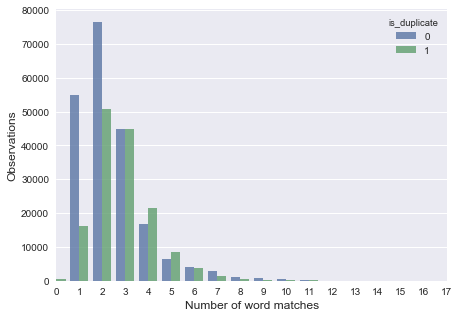

In [223]:
plt.figure(figsize=(7,5))
g1 = sns.countplot(x='n_common', data = match_cnt, 
              hue='is_duplicate', alpha=0.8)
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Number of word matches', fontsize=12)
plt.xlim(0,17)
plt.show()

2) bi-grams: two consecutive words shared by two questions

In [47]:
#use ngrams function
from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords
sw = set(stopwords.words('english')) 
from string import punctuation
punc = set(punctuation)

In [266]:
#generate bigrams for each question
def bi_grams(line):
    return [i for i in ngrams(line, 2)]

#create bigram variable
ntrain['q1_bigram'] = ntrain['q1_tokens'].apply(lambda x: bi_grams(x))
ntrain['q2_bigram'] = ntrain['q2_tokens'].apply(lambda x: bi_grams(x))

In [280]:
#find matches of bigrams between the questions
def num_bi_match(line):
    b = line['q1_bigram']
    c = line['q2_bigram']
    bl = list(map(str,b))
    cl = list(map(str,c))
    s = set(bl).intersection(set(cl)) #get duplicate bigrams
    return len(s)

ntrain["bi_common"] = ntrain.apply(lambda x: num_bi_match(x), axis = 1)

In [284]:
#temporary dataframe
bi_cnt = ntrain[['bi_common','is_duplicate']]

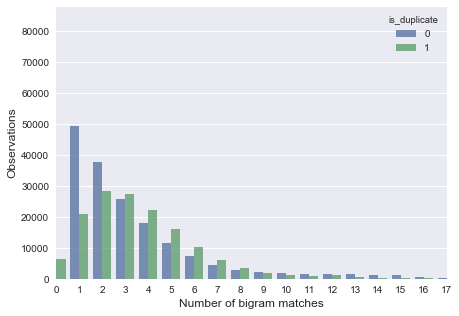

In [285]:
plt.figure(figsize=(7,5))
g1 = sns.countplot(x='bi_common', data = bi_cnt, 
              hue='is_duplicate', alpha=0.8)
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Number of bigram matches', fontsize=12)
plt.xlim(0,17)
plt.show()

3) Tri-grams: three consecutive words

In [286]:
#generate trigrams for each question
def tri_grams(line):
    return [i for i in ngrams(line, 3)]

#create bigram variable
ntrain['q1_trigram'] = ntrain['q1_tokens'].apply(lambda x: tri_grams(x))
ntrain['q2_trgram'] = ntrain['q2_tokens'].apply(lambda x: tri_grams(x))

/Users/SojungKi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: generator 'ngrams' raised StopIteration
  app.launch_new_instance()


In [293]:
def num_tri_match(line):
    b = line['q1_trigram']
    c = line['q2_trgram']
    bl = list(map(str,b))
    cl = list(map(str,c))
    s = set(bl).intersection(set(cl)) #get duplicate bigrams
    return len(s)

ntrain["tri_common"] = ntrain.apply(lambda x: num_tri_match(x), axis = 1)

In [294]:
#temporary dataframe
tri_cnt = ntrain[['tri_common','is_duplicate']]

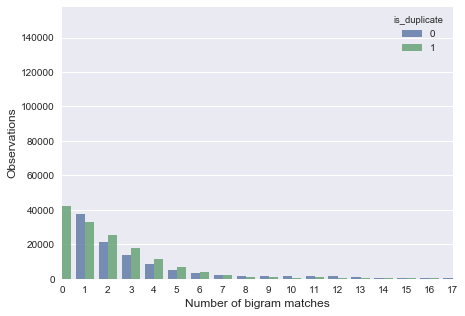

In [295]:
plt.figure(figsize=(7,5))
g1 = sns.countplot(x='tri_common', data = tri_cnt, 
              hue='is_duplicate', alpha=0.8)
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Number of bigram matches', fontsize=12)
plt.xlim(0,17)
plt.show()